In [1]:
import sys
sys.path.append("/home/federico/programming/CM/")

In [2]:
from src.LS.LS import LS
import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
import random
import sys
import time
import matplotlib.pyplot as plt

from src.NN.utils import *

from datetime import datetime as dt
import time

In [9]:
def generate(m, n):
    """Generates a random dataset starting from the given dimensions.

    :param m: Number of rows for the coefficient matrix (i.e. length of the vector b).
    :param n: Number of columns for the coefficient matrix (i.e. length of the vector x in (P)).
    :return: The coefficient matrix M and the dependent variables vector b.
    """

    M = np.array([ [random.gauss(0,1) for r in range(n)] for c in range(m) ], dtype=float)
    b = np.array([random.gauss(0,1) for r in range(m)], dtype=float)
    return M, b.reshape(-1,1)


def scaling (starting_m, m, n, step, t, save=True) :
    """Tests the QR factorization for different matrices with m in [200, 5000] and n=50.
    Executes each example for a given amount of time and averages the times accordingly. For each result
    prints the size m and the average execution time, together with the time difference from the previous
    result.

    At the end of the process, saves an image showing the evolution of execution times over the increase
    of dimension m. The resulting image is saved in the resource folder as 'QRscaling_n50.png'.
    """

    print(f"n={n}, m={m}, t={t}")
    print(f"m{'':7} QR A3{'':<5s} delta{'':<5s} QR np{'':<5s} delta{'':<5s} LS A3{'':<5s} delta{'':<5s} LS np{'':<5s} delta{'':<5s}")
    print("----------------------------------------------------------------------------------------------------")
    
    stats = ""
    
    time_qr_a3 = []
    time_qr_np = []
    time_ls_a3 = []
    time_ls_np = []
    
    prev_qr_a3 = 0
    prev_qr_np = 0
    prev_ls_a3 = 0
    prev_ls_np = 0
    
    ls = LS()
    mrange = range(starting_m,m,step)
    for m in mrange:
        
        A,b = generate(m,n)
        mean_qr_a3 = 0
        mean_qr_np = 0
        mean_ls_a3 = 0
        mean_ls_np = 0
        
        for i in range(t):
            startQR = dt.now()
            R = ls.qr(A)
            Q = ls.revertQ()
            QR = np.matmul(Q, R)
            endQR = end_time(startQR)
            endQR = endQR.seconds*1000 + endQR.microseconds/1000
            mean_qr_a3 += endQR

            startQRnp = dt.now()
            Qnp, Rnp = np.linalg.qr(A)
            QRnp = np.matmul(Qnp, Rnp)
            endQRnp = end_time(startQRnp)
            endQRnp = endQRnp.seconds*1000 + endQRnp.microseconds/1000
            mean_qr_np += endQRnp
            
            # Computes time for LS solver 
            startLS = dt.now()
            res = ls.solve(A,b)
            endLS = end_time(startLS)
            endLS = endLS.seconds*1000 + endLS.microseconds/1000
            mean_ls_a3 += endLS
            
            # Computes time for LS solver using numpy
            startLSnp = dt.now()
            resnp, _, _, _ = np.linalg.lstsq(A,b,rcond=-1)
            endLSnp = end_time(startLSnp)
            endLSnp = endLSnp.seconds*1000 + endLSnp.microseconds/1000
            mean_ls_np += endLSnp
        
        mean_qr_a3 = (mean_qr_a3 / t)
        mean_qr_np = (mean_qr_np / t)
        mean_ls_a3 = (mean_ls_a3 / t)
        mean_ls_np = (mean_ls_np / t)
        
        delta_qr_a3 = mean_qr_a3 - prev_qr_a3
        delta_qr_np = mean_qr_np - prev_qr_np
        delta_ls_a3 = mean_ls_a3 - prev_ls_a3
        delta_ls_np = mean_ls_np - prev_ls_np
        
        time_qr_a3.append(mean_qr_a3)
        time_qr_np.append(mean_qr_np)
        time_ls_a3.append(mean_ls_a3)
        time_ls_np.append(mean_ls_np)
        
        prev_qr_a3 = mean_qr_a3
        prev_qr_np = mean_qr_np
        prev_ls_a3 = mean_ls_a3
        prev_ls_np = mean_ls_np
        
        stats += (f"Solved (m x n): ({m},{n}) in {mean_ls_a3} msec, w/ np in {mean_ls_np} msec"\
        f"- Reverting and reconstruction: {mean_qr_a3} msec, w/ np took: {mean_qr_np} msec\n"\
        f"res error: {np.linalg.norm( b - np.dot(A, res) )/np.linalg.norm(b)} "\
        f"- np_res error: {np.linalg.norm( b - np.dot(A, resnp) )/np.linalg.norm(b)}\n"\
        f"QR error: {np.linalg.norm( A - QR )/np.linalg.norm(A)} "\
        f"- QR error w/ np: {np.linalg.norm( A - QRnp )/np.linalg.norm(A)}\n\n")
        
        print(f"{m:<6} || {mean_qr_a3:8.4f} | {delta_qr_a3:8.4f} | {mean_qr_np:8.4f} | {delta_qr_np:8.4f} "\
             f"| {mean_ls_a3:8.4f} | {delta_ls_a3:8.4f} | {mean_ls_np:8.4f} | {delta_ls_np:8.4f}")
        

    print(stats)
    
    # --- Plotting QR stats ---
    plt.plot(mrange, time_qr_np, "^-", label="np")
    plt.xlabel ("m")
    plt.ylabel ("time (msec)")
    plt.title (f"QR factorizzation of a matrix {m}x{n} (NP)")
    plt.gca().set_xlim ((min(mrange)-1, max(mrange)+1))

    if save: plt.savefig(f"report_tests/LS/Scaling/QRscaling_np_n{n}m{m}.png")
    else: plt.show()
    plt.clf()

    plt.plot (mrange, time_qr_a3, "o-", label="mio")
    plt.xlabel ("m")
    plt.ylabel ("time (msec)")
    plt.title (f"QR factorizzation of a matrix {m}x{n} (A3)")
    plt.gca().set_xlim ((min(mrange)-1, max(mrange)+1))

    if save: plt.savefig(f"report_tests/LS/Scaling/QRscaling_a3_n{n}m{m}.png")
    else: plt.show()
    plt.clf()
    
    plt.plot(mrange, time_qr_np, "^-", label="np")
    plt.plot (mrange, time_qr_a3, "o-", label="(A3)")
    plt.legend()
    plt.xlabel ("m")
    plt.ylabel ("time (msec)")
    plt.title (f"QR factorizzation of a matrix {m}x{n}")
    plt.gca().set_xlim ((min(mrange)-1, max(mrange)+1))

    if save: plt.savefig(f"report_tests/LS/Scaling/QRscaling_comparison_n{n}m{m}.png")
    else: plt.show()
    plt.clf()
    
    
    # --- Plotting LS stats ---
    plt.plot(mrange, time_ls_np, "^-")
    plt.xlabel ("m")
    plt.ylabel ("time (msec)")
    plt.title (f"LS of a matrix {m}x{n} (NP)")
    plt.gca().set_xlim ((min(mrange)-1, max(mrange)+1))

    if save: plt.savefig(f"report_tests/LS/Scaling/LSscaling_np_n{n}m{m}.png")
    else: plt.show()
    plt.clf()

    plt.plot (mrange, time_ls_a3, "o-")
    plt.xlabel ("m")
    plt.ylabel ("time (msec)")
    plt.title (f"LS of a matrix {m}x{n} (A3)")
    plt.gca().set_xlim ((min(mrange)-1, max(mrange)+1))

    if save: plt.savefig(f"report_tests/LS/Scaling/LSscaling_a3_n{n}m{m}.png")
    else: plt.show()
    plt.clf()
    
    plt.plot(mrange, time_qr_np, "^-", label="np")
    plt.plot (mrange, time_qr_a3, "o-", label="(A3)")
    plt.legend()
    plt.xlabel ("m")
    plt.ylabel ("time (msec)")
    plt.title (f"LS of a matrix {m}x{n}")
    plt.gca().set_xlim ((min(mrange)-1, max(mrange)+1))

    if save: plt.savefig(f"report_tests/LS/Scaling/LSscaling_comparison_n{n}m{m}.png")
    else: plt.show()
    plt.clf()
    

def automatized_test(M, b, test_type):
    ls = LS()
    m = M.shape[0]
    n = M.shape[1]

    # Computes time for LS solver 
    startLS = dt.now()
    res = ls.solve(M,b)
    endLS = end_time(startLS)
    endLS = endLS.seconds*1000 + endLS.microseconds/1000

    # Computes time for Q and QR reconstruction
    startQR = dt.now()
    R = ls.qr(M)
    Q = ls.revertQ()
    QR = np.matmul(Q, R)
    endQR = end_time(startQR)
    endQR = endQR.seconds*1000 + endQR.microseconds/1000

    # Computes QR factorization using numpy
    startQRnp = dt.now()
    Qnp, Rnp = np.linalg.qr(M)
    QRnp = np.matmul(Qnp, Rnp)
    endQRnp = end_time(startQRnp)
    endQRnp = endQRnp.seconds*1000 + endQRnp.microseconds/1000

    # Computes time for LS solver using numpy
    startLSnp = dt.now()
    resnp, _, _, _ = np.linalg.lstsq(M,b,rcond=-1)
    endLSnp = end_time(startLSnp)
    endLSnp = endLSnp.seconds*1000 + endLSnp.microseconds/1000

    print(f"---------- {test_type} DATASET ----------")
    print(f"Solved (m x n): ({m},{n}) in {endLS} msec, w/ np in {endLSnp} msec \
    - Reverting and reconstruction: {endQR} msec, w/ np took: {endQRnp} msec")
    print(f"res error: {np.linalg.norm( b - np.dot(M, res) )/np.linalg.norm(b)} "\
    f"- np_res error: {np.linalg.norm( b - np.dot(M, resnp) )/np.linalg.norm(b)}")
    print(f"QR error: {np.linalg.norm( M - QR )/np.linalg.norm(M)} "\
    f"- QR error w/ np: {np.linalg.norm( M - QRnp )/np.linalg.norm(M)}\n")   

# Scaling test

n=100, m=11000, t=20
m        QR A3      delta      QR np      delta      LS A3      delta      LS np      delta     
----------------------------------------------------------------------------------------------------
1000   || 267.5245 | 267.5245 |  24.5174 |  24.5174 |  51.7239 |  51.7239 |   9.3152 |   9.3152
2000   || 363.1921 |  95.6676 |  20.6952 |  -3.8222 |  87.5392 |  35.8153 |  11.7285 |   2.4132
3000   || 495.0688 | 131.8767 |  22.0556 |   1.3605 | 134.5601 |  47.0209 |  17.3503 |   5.6219
4000   || 616.7704 | 121.7016 |  35.7867 |  13.7311 | 167.0992 |  32.5392 |  21.3943 |   4.0439
5000   || 772.9888 | 156.2184 |  33.4422 |  -2.3445 | 230.8502 |  63.7510 |  26.5720 |   5.1777
6000   || 873.5516 | 100.5628 |  41.7227 |   8.2805 | 274.3465 |  43.4963 |  27.5265 |   0.9545
7000   || 1024.4368 | 150.8852 |  54.9743 |  13.2516 | 331.0953 |  56.7488 |  35.5769 |   8.0504
8000   || 1194.4305 | 169.9937 |  67.1786 |  12.2043 | 392.7680 |  61.6727 |  37.4923 |   1.9154
9000   || 1

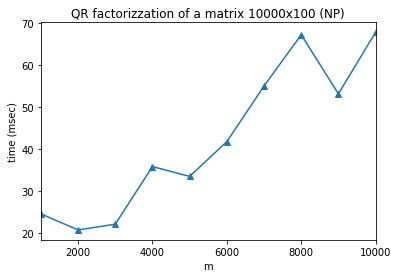

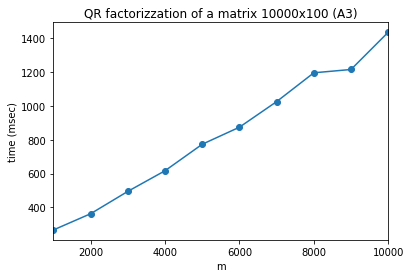

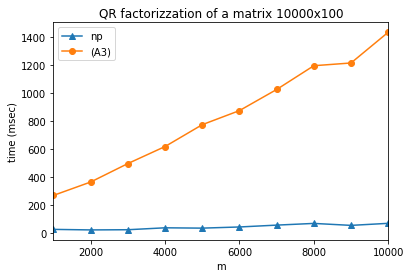

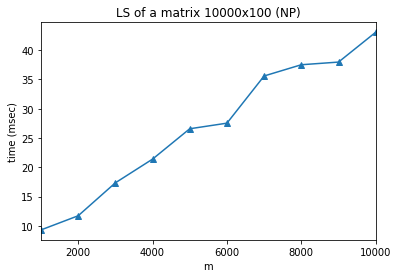

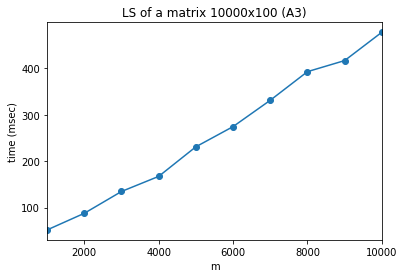

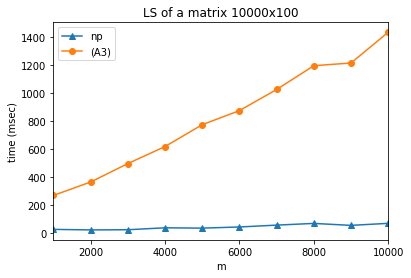

<Figure size 432x288 with 0 Axes>

In [10]:
starting_m = 1000
last_m = 11000
n = 100
step = 1000
repeat = 20
scaling(starting_m, last_m, n, step, repeat, save=False)

# CUP test

In [4]:
cup = '../../data/ML-CUP20-TR.csv'

In [5]:
M, _, b, _ = load_CUP(cup, split=0)
automatized_test(M, b, 'cup')

---------- cup DATASET ----------
Solved (m x n): (1524,10) in 9.38 msec, w/ np in 0.77 msec     - Reverting and reconstruction: 7.169 msec, w/ np took: 1.095 msec
res error: 1.0537730959643323 - np_res error: 0.9962999753126451
QR error: 4.933387024233579e-16 - QR error w/ np: 3.2893174070752366e-16



# Random test

In [23]:
last_m = 10000    # number of rows
n = 200    # number of cols

for m in range(1000, last_m, 1000):
    M, b = generate(m, n)
    automatized_test(M, b, 'RANDOM')

---------- RANDOM DATASET ----------
Solved (m x n): (1000,200) in 95.739 msec, w/ np in 23.38 msec     - Reverting and reconstruction: 734.778 msec, w/ np took: 18.606 msec
res error: 1.1054073572158813 - np_res error: 0.9098960161209106
QR error: 4.525045653736015e-07 - QR error w/ np: 7.4717512177358e-08

---------- RANDOM DATASET ----------
Solved (m x n): (2000,200) in 196.704 msec, w/ np in 39.599 msec     - Reverting and reconstruction: 1169.431 msec, w/ np took: 38.916 msec
res error: 1.040412425994873 - np_res error: 0.9505425095558167
QR error: 4.5352408051257953e-07 - QR error w/ np: 6.234025562434908e-08

---------- RANDOM DATASET ----------
Solved (m x n): (3000,200) in 202.002 msec, w/ np in 44.014 msec     - Reverting and reconstruction: 1411.47 msec, w/ np took: 50.897 msec
res error: 1.033128261566162 - np_res error: 0.9632071256637573
QR error: 4.6125546759867575e-07 - QR error w/ np: 5.392552893113134e-08

---------- RANDOM DATASET ----------
Solved (m x n): (4000,20

In [ ]:
MONK_TEST = 'MONK'


elif test == MONK_TEST:
    assert len(sys.argv) == 3, "This kind of test requires dataset path to be defined."
    M, b = load_monk(sys.argv[2])
    automatized_test(M, b, test)